# 1. Decision Tree for Spotify Data

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

### 1.1 Import Data

In [2]:
spotify_data = pd.read_csv("Q1/spotify_data.csv")
spotify_data.drop('Unnamed: 0', axis=1, inplace=True)

targets = spotify_data["target"].to_frame() # saving the targets in another dataframe

In [3]:
# converting categorical features into numerical
label_encoder = preprocessing.LabelEncoder()
spotify_data['song_title']= label_encoder.fit_transform(spotify_data['song_title'])
spotify_data['artist']= label_encoder.fit_transform(spotify_data['artist'])

In [4]:
corr = spotify_data.corr()

<Axes: >

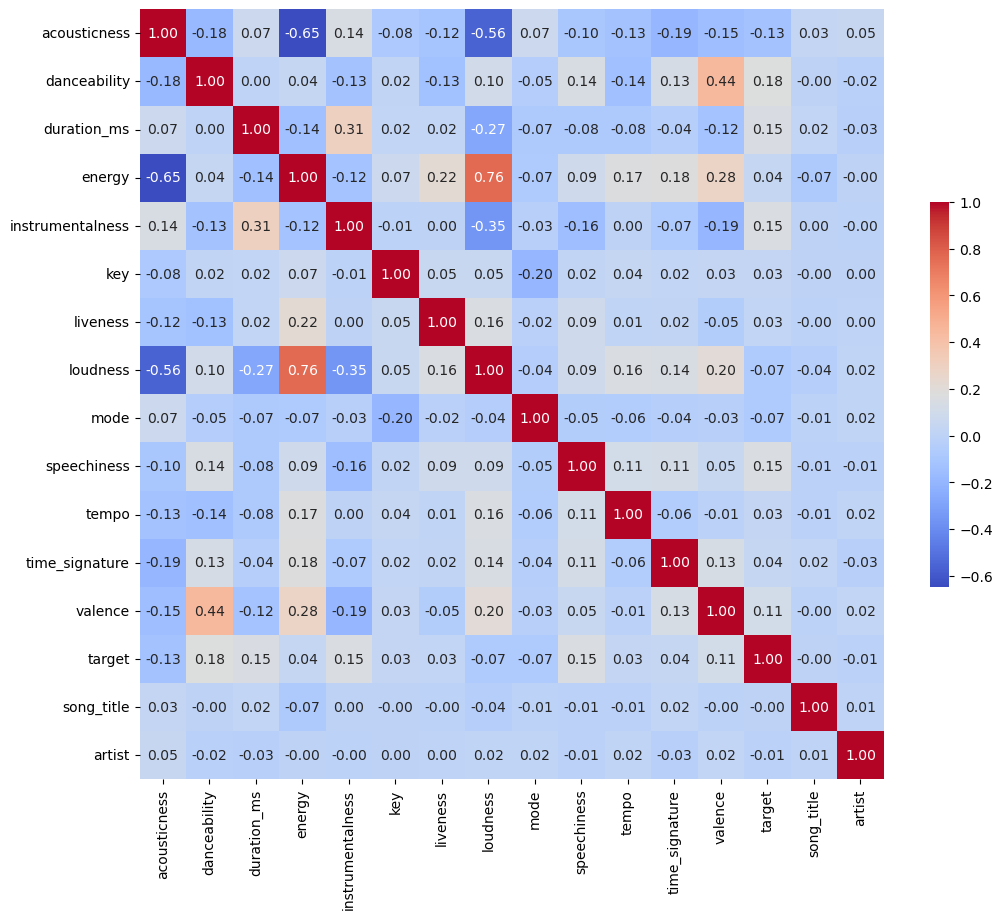

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr,annot=True,fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .5})

In [6]:
spotify_data.drop('target', axis=1, inplace=True)

/Users/artijain/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


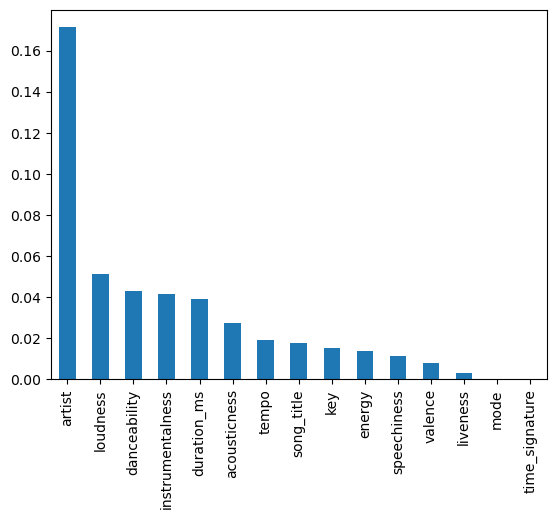

In [7]:
mi_scores = mutual_info_classif(spotify_data, targets) # calculates the mututal info
mi_scores_series = pd.Series(mi_scores, index=spotify_data.columns) # match the scores with the features
mi_scores_series = mi_scores_series.sort_values(ascending=False) # sort from more relevant to least
mi_scores_series.plot(kind='bar') # plot scores
plt.show()

In [8]:
mi_scores_series

artist              0.171339
loudness            0.051454
danceability        0.042902
instrumentalness    0.041287
duration_ms         0.039173
acousticness        0.027626
tempo               0.018934
song_title          0.017821
key                 0.015058
energy              0.013617
speechiness         0.011153
valence             0.007866
liveness            0.002839
mode                0.000000
time_signature      0.000000
dtype: float64

In [9]:
print(mi_scores_series > 0.017)

artist               True
loudness             True
danceability         True
instrumentalness     True
duration_ms          True
acousticness         True
tempo                True
song_title           True
key                 False
energy              False
speechiness         False
valence             False
liveness            False
mode                False
time_signature      False
dtype: bool


In [10]:
def load_data():
    """ Load Data Set, making sure to import the index column correctly
        Arguments:
            None
        Returns:
            Training data dataframe, training labels, testing data dataframe,
            testing labels, features list
    """
    spotify_data = pd.read_csv("Q1/spotify_data.csv")
    spotify_data.drop('Unnamed: 0', axis=1, inplace=True)

    targets = spotify_data["target"].to_frame() # saving the targets in another dataframe
    spotify_data.drop('target', axis=1, inplace=True)
    
    label_encoder = preprocessing.LabelEncoder() # convert artist to numerical data
    spotify_data['artist']= label_encoder.fit_transform(spotify_data['artist'])
    
    useless_features = ["song_title", "energy", "valence", "key", "liveness", "mode", "time_signature"] # dropping uninformative features
    spotify_data.drop(useless_features, axis=1, inplace=True)
    features = list(spotify_data.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(spotify_data,targets,test_size=0.2,random_state=42) # splitting data
    return (X_train, X_test, y_train, y_test), features
    

### 1.2 Training the Model

In [11]:
def cv_grid_search(training_table, training_labels):
    """ Run grid search with cross-validation to try different
    hyperparameters
        Arguments:
            Training data dataframe and training labels
        Returns:
            Dictionary of best hyperparameters found by a grid search with
            cross-validation
    """
    decision_tree = DecisionTreeClassifier()
    grid_search = GridSearchCV(estimator=decision_tree, param_grid={
                                        'criterion':['gini', 'entropy', 'log_loss'],
                                         'max_depth':[3, 6, 9, 12, 15, 18, 21, 24, 27],
                                         'class_weight':[{0:1, 1:1}, {0:2, 1:1}, {0:1, 1:2}]})
    grid_search.fit(training_table, training_labels)
    
    optimal_hyperparams = grid_search.best_params_
    print("Optimal Hyperparameters", optimal_hyperparams)
    return optimal_hyperparams

### 1.3 Evaluating the Model

In [12]:
def plot_confusion_matrix(test_labels, pred_labels):
    """Plot confusion matrix
        Arguments:
            ground truth labels and predicted labels
        Returns:
            Writes image file of confusion matrix
    """
    confusion_matrix = metrics.confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True,fmt=".2f", cmap="crest", cbar_kws={"shrink": .5})
    plt.title("Confusion Matrix")
    plt.savefig('spotify_confusion_matrix.png')

In [13]:
def graph_tree(model, training_features, class_names):
    """ Plot the tree of the trained model
        Arguments:
            Trained model, list of features, class names
        Returns:
            Writes PDF file showing decision tree representation
    """
    graph = graphviz.Source(export_graphviz(model, out_file=None, filled=True, feature_names=training_features, class_names=class_names))
    graph.render('spotify_decision_tree')

In [14]:
def print_results(predictions, test_y):
    """Print results
        Arguments:
            Ground truth labels and predicted labels
        Returns:
            Prints precision, recall, F1-score, and accuracy
    """
    ps = precision_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    f1 = f1_score(test_y, predictions)
    accuracy = accuracy_score(test_y, predictions)
    
    print(f"Precision: {ps}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

In [15]:
def print_feature_importance(model, features):
    """Print feature importance
        Arguments:
            Trained model and list of features
        Returns:
            Prints ordered list of features, starting with most important,
            along with their relative importance (percentage).
    """
    fi = model.feature_importances_
    feature_import = {"Feature": features,
                      "Importance": fi}
    fi_df = pd.DataFrame(feature_import)
    fi_df = fi_df.sort_values(by='Importance', ascending=False)
    print(fi_df)
    
    

### Running the program

In [16]:
"""Run the program"""
# Load data
(train_x, test_x, train_y, test_y), features = load_data()

# Cross Validation Training
params = cv_grid_search(train_x, train_y)

# Train and test model using hyperparameters
decision_tree = DecisionTreeClassifier(criterion=params['criterion'], class_weight=params['class_weight'], max_depth=params['max_depth']) 
decision_tree.fit(train_x, train_y)
test_acc = decision_tree.score(test_x,test_y)
print("Test accuracy = ", test_acc)

Optimal Hyperparameters {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 6}
Test accuracy =  0.7103960396039604


In [17]:
predictions = decision_tree.predict(test_x)

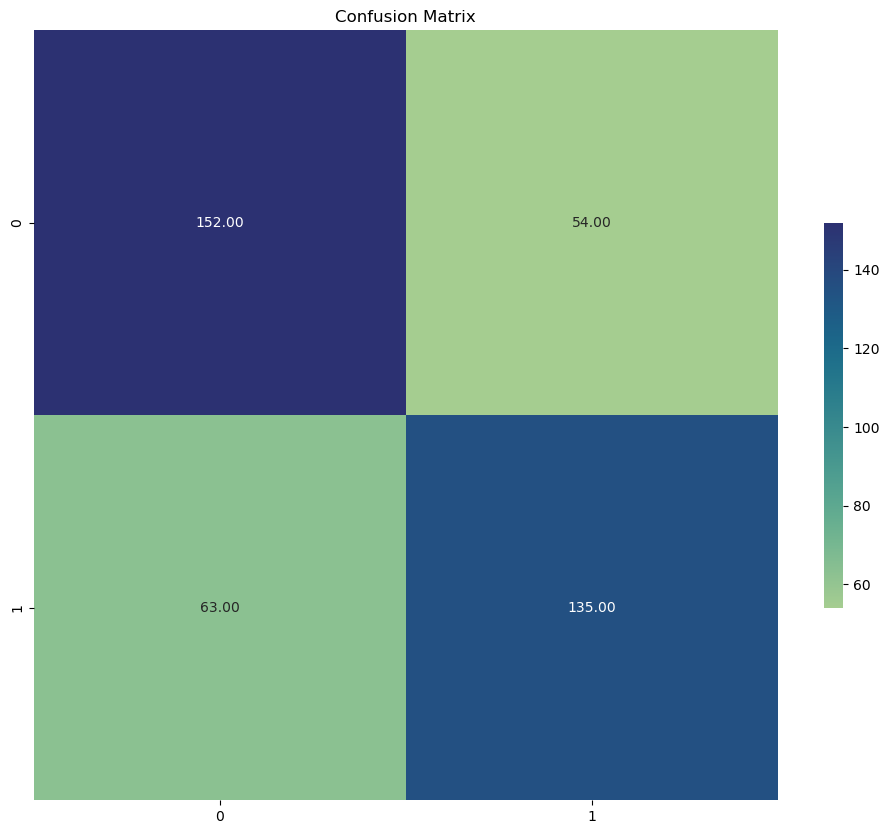

In [18]:
predictions = decision_tree.predict(test_x)

# Confusion Matrix
plot_confusion_matrix(test_y, list(predictions))

In [19]:
# Graph Tree
graph_tree(decision_tree, features, ['hate', 'love'])

In [20]:
# Accuracy, Precision, Recall, F1
print_results(predictions, test_y)

Precision: 0.7142857142857143
Recall: 0.6818181818181818
F1 Score: 0.6976744186046512
Accuracy: 0.7103960396039604


In [21]:
# Feature Importance
print_feature_importance(decision_tree, features)

            Feature  Importance
3  instrumentalness    0.280505
4          loudness    0.171003
0      acousticness    0.153555
5       speechiness    0.151504
1      danceability    0.099355
2       duration_ms    0.059629
6             tempo    0.051155
7            artist    0.033293
